<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png"></a>

# DataRecord Tutorial

<hr>
<small> For instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/release/README.md">https://github.com/landlab/tutorials/blob/release/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="https://nbviewer.jupyter.org/github/landlab/tutorials/blob/release/fault_scarp/landlab-fault-scarp-unexpanded.ipynb">https://nbviewer.jupyter.org/github/landlab/tutorials/blob/release/fault_scarp/landlab-fault-scarp-unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>


This tutorial illustrates how to record variables of a Landlab model using DataRecord.

## What is DataRecord?
DataRecord is a data structure that can hold data variables relating to a Landlab model or to items living on the [Landlab grid](https://nbviewer.jupyter.org/github/landlab/tutorials/blob/release/grid_object_demo/grid_object_demo.ipynb).

DataRecord is built on [xarray](http://xarray.pydata.org/en/stable/index.html)'s Dataset structure: a multi-dimensional, in memory, array database. Dataset implements the mapping interface with keys given by variable names and values given by DataArray objects for each variable name. DataRecord inherits all the methods and attributes from xarray.Dataset.

A DataRecord can have one or both (or none) of the following dimensions:
- `time`: The simulated time in the model.
- `item_id`: An identifier of a generic item in the model.

Coordinates are one dimensional arrays used for label-based indexing.  

The examples below illustrate different use cases for DataRecord.  

We start by importing the necessary libraries:

In [1]:
import numpy as np
from landlab import RasterModelGrid
from landlab.data_record import DataRecord

from landlab import imshow_grid
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, subplot, xlabel, ylabel, title, legend, figure
%matplotlib inline

## Case 1. DataRecord with 1 dimension: time
Let's start with an example where we set DataRecord to have only `time` as a dimension.
An example variable that varies over time and relates to the Landlab grid could be the mean elevation of the topographic surface. We will store this example variable in DataRecord.

We create a Raster grid, create a field (at nodes) called `topographic__elevation` and populate it with random values.

In [2]:
grid_1 = RasterModelGrid((10, 10), (1., 1.))
z = np.random.rand(100)
_ = grid_1.add_field('node', 'topographic__elevation', z)

Print the current mean elevation.

In [3]:
current_mean = np.mean(grid_1.at_node['topographic__elevation'])
print(current_mean)

0.459605844411


Now we will create a DataRecord that will hold the data variable `mean_elevation` relating to `grid_1`. The first value, at time=0 is the current mean elevation on the grid.

In [4]:
dr_1 = DataRecord(grid_1,
                  time=[0.],
                  items=None,
                  data_vars={'mean_elevation' : (['time'], ([current_mean]))},
                  attrs={'mean_elevation' : 'y'})

The input arguments passed in this case are: the grid, time (as a 1-element list), a data variable dictionary and an attributes dictionary. Note that `items` is not filled, we will see its use in other cases below.

Note the format of the `data_vars` dictionary:  
```python
    {'variable_name_1' : (['dimensions'], variable_data_1),
     'variable_name_2' : (['dimensions'], variable_data_2),
     ...}
```

The attributes dictionary `attrs` can be used to store metadata about the variables: in this example, we use it to store the variable units.

So far, our DataRecord `dr_1` holds one variable `mean_elevation` with one record at time=0.


In [5]:
dr_1

<xarray.DataRecord>
Dimensions:         (time: 1)
Coordinates:
  * time            (time) float64 0.0
Data variables:
    mean_elevation  (time) float64 0.4596
Attributes:
    mean_elevation:  y

We can visualise this data structure as a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html):

In [6]:
dr_1.to_dataframe()

,mean_elevation
time,
0.0,0.459606


Now we will run a simple model where the grid surface is uplifted several times and the mean elevation is recorded at every time step. We use the method `add_record` to put the new value in the DataRecord `dr_1`:

In [7]:
total_time = 100
dt = 20

uplift_rate = 0.01 # m/y

for t in range(20, total_time, dt):
    grid_1.at_node['topographic__elevation'] += uplift_rate * dt
    dr_1.add_record(time=[t],
                   new_record={'mean_elevation' : (['time'], ([np.mean(grid_1.at_node['topographic__elevation'])]))})
    

Let's see what was recorded:

In [8]:
dr_1['mean_elevation'].values

array([ 0.45960584,  0.65960584,  0.85960584,  1.05960584,  1.25960584])

The corresponding time coordinates are:

In [9]:
dr_1.time.values

array([  0.,  20.,  40.,  60.,  80.])

Notice the different syntax used here: 
- `time` is a **dimension** and can be called by `dr_1.time` (or `dr_1['time']`)
- whereas `mean_elevation` is a **variable** and must be called by `dr_1['mean_elevation']`

DataRecord also has the handy property `time_coordinates` that returns these values as a list:




In [10]:
dr_1.time_coordinates

[0.0, 20.0, 40.0, 60.0, 80.0]

You can use the methods `get_data` and `set_data` to access and change the data:

In [11]:
dr_1.get_data(time=[20.], data_variable='mean_elevation')

array(0.6596058444111567)

In [12]:
dr_1.set_data(time=[80.], data_variable='mean_elevation', new_value=1.5)

dr_1['mean_elevation']

<xarray.DataArray 'mean_elevation' (time: 5)>
array([ 0.459606,  0.659606,  0.859606,  1.059606,  1.5     ])
Coordinates:
  * time     (time) float64 0.0 20.0 40.0 60.0 80.0

## Case 2. DataRecord with 1 dimension: item_id
An important feature of DataRecord is that it allows to create **items** that live on grid elements, and variables describing them. For instance, we can create *boulders* and store information about their *size* and *lithology*.

To create items, we need to instantiate a DataRecord and pass it a dictionary describing where each item lives on the Landlab grid. The format of this dictionary is:  
```python
    {'grid_element' : [grid_element],
     'element_id' : [element_id]}
```
  
where:
- `grid_element` is a str or number-of-items-long array containing strings of the grid element(s) on which the items live (e.g.: node, link). Valid locations depend on the grid type (`my_grid.groups` gives the valid locations for your grid). If `grid_element` is provided as a string, it is assumed that all items live on the same type of grid element.
- `element_id` is an array of integers identifying the grid element IDs on which each item resides. For each item, `element_id` must be less than the number of this item's `grid_element` that exist on the grid. For example, if the grid has 10 links, no item can live at link 10 or link -3 because only links 0 to 9 exist in this example.


In [13]:
grid_2 = RasterModelGrid((5, 5), (2, 2))

boulders = {'grid_element' : 'node',
            'element_id' : np.array([6, 11, 12, 17, 12])}

initial_boulder_sizes = np.array([1, 1.5, 3, 1, 2])
boulder_lithologies = np.array(['sandstone', 'granite', 'sandstone', 'sandstone', 'limestone'])

dr_2 = DataRecord(grid_2,
                 time=None,
                 items=boulders,
                 data_vars={'boulder_size': (['item_id'], initial_boulder_sizes),
                           'boulder_litho': (['item_id'], boulder_lithologies)},
                 attrs={'boulder_size': 'm'})
dr_2.to_dataframe()

,grid_element,element_id,boulder_size,boulder_litho
item_id,,,,
0,node,6,1.0,sandstone
1,node,11,1.5,granite
2,node,12,3.0,sandstone
3,node,17,1.0,sandstone
4,node,12,2.0,limestone


Each *item* (in this case, each boulder) is designated by an `item_id`, its position on the grid is described by a `grid_element` and an `element_id`.

We can use the method `add_item` to add new boulders to the record:

In [14]:
dr_2.add_item(new_item={'grid_element': np.array(['link', 'node']),
                        'element_id': np.array([24, 8])},
              new_item_spec={'boulder_size': (['item_id'], np.array([1.2, 2.]))})

dr_2.to_dataframe()

,grid_element,element_id,boulder_size,boulder_litho
item_id,,,,
0,node,6.0,1.0,sandstone
1,node,11.0,1.5,granite
2,node,12.0,3.0,sandstone
3,node,17.0,1.0,sandstone
4,node,12.0,2.0,limestone
5,link,24.0,1.2,NaN
6,node,8.0,2.0,NaN


Notice that we did not specify the lithologies of the new boulders, their recorded values are thus set as `NaN`. We can use the `set_data` method to report the boulder lithologies: 

In [15]:
dr_2.set_data(data_variable='boulder_litho',
              item_id=[5, 6],
              new_value=['sandstone', 'granite'])
dr_2.to_dataframe()

,grid_element,element_id,boulder_size,boulder_litho
item_id,,,,
0,node,6.0,1.0,sandstone
1,node,11.0,1.5,granite
2,node,12.0,3.0,sandstone
3,node,17.0,1.0,sandstone
4,node,12.0,2.0,limestone
5,link,24.0,1.2,sandstone
6,node,8.0,2.0,granite


We can use the method `calc_aggregate_value` to apply a function to a variable aggregated at grid elements. For example, we can calculate the mean size of boulders on each node:

In [16]:
mean_size = dr_2.calc_aggregate_value(func=np.mean,
                                      data_variable='boulder_size')
mean_size

array([ nan,  nan,  nan,  nan,  nan,  nan,  1. ,  nan,  2. ,  nan,  nan,
        1.5,  2.5,  nan,  nan,  nan,  nan,  1. ,  nan,  nan,  nan,  nan,
        nan,  nan,  nan])

Notice that boulder #5 is on a link so it is not taken into account in this calculation.

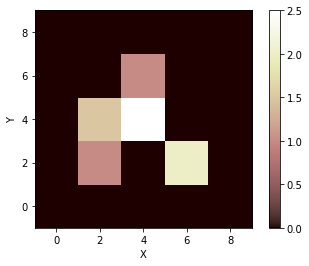

In [17]:
# replace nans with 0:
mean_size[np.isnan(mean_size)] = 0

# show unfiltered mean sizes on the grid:
imshow_grid(grid_2, mean_size)

Before doing this calculation we could filter by lithology and only use the 'sandstone' boulders in the calculation:

In [18]:
# define a filter array:
filter_litho = (dr_2['boulder_litho'] == 'sandstone')

# aggregate by node and apply function numpy.mean on boulder_size
filtered_mean = dr_2.calc_aggregate_value(func=np.mean,
                                          data_variable='boulder_size',
                                          at='node',
                                          filter_array=filter_litho)

filtered_mean

array([ nan,  nan,  nan,  nan,  nan,  nan,   1.,  nan,  nan,  nan,  nan,
        nan,   3.,  nan,  nan,  nan,  nan,   1.,  nan,  nan,  nan,  nan,
        nan,  nan,  nan])

## Case 3. DataRecord with 2 dimensions: item_id and time

We may want to record variables that have both dimensions `time` *and* `item_id`.

In the previous example, some variables that characterize the items (boulders) may not vary with time, such as `boulder_lithology`. Although it can be interesting to keep track of the change in size through time. We will redefine the DataRecord such that the variable `boulder_size` varies among the items/boulders (identified by `item_id`) and through `time`. The variable `boulder_litho` varies only among the items/boulders and this lithogy variable does not vary through time.

In [19]:
grid_3 = RasterModelGrid((5, 5), (2, 2))

initial_boulder_sizes_3 = np.array([[10], [4], [8], [3], [5]])
# boulder_lithologies = np.array(['sandstone', 'granite', 'sandstone', 'sandstone', 'limestone']) #same as above, already run

boulders_3 = {'grid_element' : 'node',
            'element_id' : np.array([[6], [11], [12], [17], [12]])}

dr_3 = DataRecord(grid_3,
                  time=[0.],
                  items=boulders_3,
                  data_vars={'boulder_size' : (['item_id', 'time'], initial_boulder_sizes_3),
                             'boulder_litho': (['item_id'], boulder_lithologies)}, 
                  attrs={'boulder_size' : 'm'})
dr_3

<xarray.DataRecord>
Dimensions:        (item_id: 5, time: 1)
Coordinates:
  * time           (time) float64 0.0
  * item_id        (item_id) int64 0 1 2 3 4
Data variables:
    grid_element   (item_id, time) object 'node' 'node' 'node' 'node' 'node'
    element_id     (item_id, time) int64 6 11 12 17 12
    boulder_size   (item_id, time) int64 10 4 8 3 5
    boulder_litho  (item_id) <U9 'sandstone' 'granite' ... 'limestone'
Attributes:
    boulder_size:  m

Note that the syntax to define the `initial_boulder_sizes_3` (as well as `element_id`) has changed: they are  number-of-items-by-1 arrays because they vary along both `time` and `item_id` (compared to `boulder_lithologies` which is just number-of-items long as it only varies along `item_id`).

In [20]:
boulder_lithologies.shape, initial_boulder_sizes.shape, initial_boulder_sizes_3.shape

((5,), (5,), (5, 1))

Let's define a very simple erosion law for the boulders:

$$
\begin{equation}
\frac{dD}{dt} = -k_{b} . D
\end{equation}
$$

where $D$ is the boulder diameter $[L]$ (this value represents the `boulder_size` variable), $t$ is time, and $k_{b}$ is the block erodibility $[L.T^{-1}]$.

We will now model boulder erosion and use DataRecord to store their size through time.

In [21]:
dt = 100
total_time = 100000

time_index = 1

for t in range(dt, total_time, dt):

    # create a new time coordinate:
    dr_3.add_record(time=np.array([t]))

    # this propagates grid_element and element_id values forward in time (instead of the 'nan' default filling):
    dr_3.ffill_grid_element_and_id() 

    for i in range(0, dr_3.number_of_items):
        # value of block erodibility:
        if dr_3['boulder_litho'].values[i] == 'limestone':
            k_b = 10**-5
        elif dr_3['boulder_litho'].values[i] == 'sandstone':
            k_b = 3*10**-6
        elif dr_3['boulder_litho'].values[i] == 'granite':
            k_b = 3*10**-7
        else:
            print('Unknown boulder lithology')

        dr_3['boulder_size'].values[i, time_index] = dr_3['boulder_size'].values[i, time_index-1] - k_b * dr_3['boulder_size'].values[i, time_index-1] * dt

    time_index += 1

print('Done')

Done


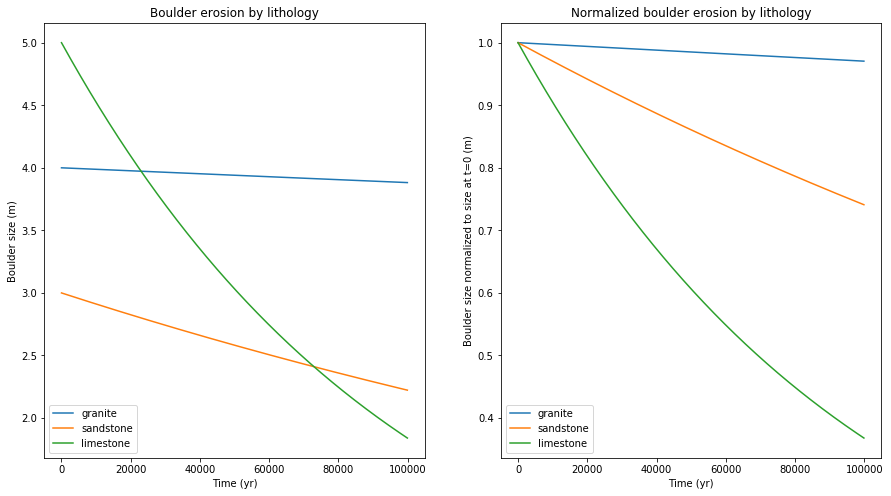

In [22]:
figure(figsize=(15, 8))

time = range(0, total_time, dt)
boulder_size = dr_3['boulder_size'].values

subplot(121)
plot(time, boulder_size[1], label='granite')
plot(time, boulder_size[3], label='sandstone')
plot(time, boulder_size[-1], label='limestone')
xlabel('Time (yr)')
ylabel('Boulder size (m)')
legend(loc='lower left')
title('Boulder erosion by lithology')

# normalized plots
subplot(122)
plot(time, boulder_size[1] / boulder_size[1, 0], label='granite')
plot(time, boulder_size[2] / boulder_size[2, 0], label='sandstone')
plot(time, boulder_size[-1] / boulder_size[-1, 0], label='limestone')
xlabel('Time (yr)')
ylabel('Boulder size normalized to size at t=0 (m)')
legend(loc='lower left')
title('Normalized boulder erosion by lithology')
plt.show()

## Other properties provided by DataRecord

In [23]:
dr_3.variable_names

['grid_element', 'element_id', 'boulder_size', 'boulder_litho']

In [24]:
dr_3.number_of_items 

5

In [25]:
dr_3.item_coordinates

[0, 1, 2, 3, 4]

In [26]:
dr_3.number_of_timesteps

1000

In [27]:
dr_1.time_coordinates

[0.0, 20.0, 40.0, 60.0, 80.0]

In [28]:
dr_1.earliest_time

0.0

In [29]:
dr_1.latest_time

80.0

In [30]:
dr_1.prior_time

60.0

# More on DataRecord

DataRecord is the data structure on which the following Landlab components are based:
- ClastTracker (coming soon)
- SpeciesEvolver (coming soon)